In [73]:
#Importing Importent Libraries
import pandas as pd
import time
import re
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Text Preprocessing
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

#Model Train and Evaluate
from sklearn.metrics import classification_report , accuracy_score , confusion_matrix , plot_roc_curve
from sklearn.svm import SVC

import warnings as wr
wr.filterwarnings("ignore")

In [5]:
#Import Dataset

train_data = pd.read_csv("Corona_NLP_train.csv",encoding="latin1")
test_data = pd.read_csv("Corona_NLP_test.csv",encoding="latin1")

In [7]:
#Dataset Exploration

print(f"Train Dataset Shape : {train_data.shape}\nTest Dataset Shape : {test_data.shape}")

Train Dataset Shape : (41157, 6)
Test Dataset Shape : (3798, 6)


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


In [11]:
train_data.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [12]:
test_data.isnull().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

In [17]:
train_data.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [18]:
#Remove Unrelevant features
unrelevant_features = ['UserName', 'ScreenName', 'Location', 'TweetAt']
train_data.drop(unrelevant_features , axis=1,inplace=True)

In [19]:
test_data.drop(unrelevant_features , axis=1 , inplace=True)

In [20]:
print(f"Train Dataset Shape : {train_data.shape}\nTest Dataset Shape : {test_data.shape}")

Train Dataset Shape : (41157, 2)
Test Dataset Shape : (3798, 2)


In [21]:
train_data.Sentiment.value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [22]:
#Separate class train data

train_positive = train_data[(train_data.Sentiment == "Positive") | (train_data.Sentiment == "Extremely Positive")]
train_negative = train_data[(train_data.Sentiment == "Negative") | (train_data.Sentiment == "Extremely Negative")]
train_neutral = train_data[train_data.Sentiment == "Neutral"]

In [25]:
print(f"train_positive Dataset Shape : {train_positive.shape}\ntrain_negative Dataset Shape : {train_negative.shape}\ntrain_neutral Dataset Shape : {train_neutral.shape}")

train_positive Dataset Shape : (18046, 2)
train_negative Dataset Shape : (15398, 2)
train_neutral Dataset Shape : (7713, 2)


In [27]:
#Separate class test data
test_positive = test_data[(test_data.Sentiment == "Positive") | (test_data.Sentiment == "Extremely Positive")]
test_negative = test_data[(test_data.Sentiment == "Negative") | (test_data.Sentiment == "Extremely Negative")]
test_neutral  = test_data[test_data.Sentiment == "Neutral"]

In [28]:
print(f"test_positive Dataset Shape : {test_positive.shape}\ntest_negative Dataset Shape : {test_negative.shape}\ntest_neutral Dataset Shape : {test_neutral.shape}")

test_positive Dataset Shape : (1546, 2)
test_negative Dataset Shape : (1633, 2)
test_neutral Dataset Shape : (619, 2)


In [29]:
train_positive.Sentiment = 2
test_positive.Sentiment  = 2

train_negative.Sentiment = 0
test_negative.Sentiment  = 0 

train_neutral.Sentiment  = 1
test_neutral.Sentiment   = 1

In [33]:
train_positive.Sentiment.unique()

array([2])

In [34]:
#Marge All DataFrame

data_set = pd.concat([
    
    train_positive,
    train_negative,
    train_neutral,
    
    test_positive,
    test_negative,
    test_neutral
    
])

In [35]:
data_set.shape

(44955, 2)

In [40]:
#Dataset Exploration

for i in range(1,5):
    random_num = random.randint(0,len(data_set))
    print(data_set.OriginalTweet[random_num] , end = "\nLabel : ")
    print(data_set.Sentiment[random_num] , end = "\n\n")

SAFEWAY IS HIRING Safeway is hiring for 1 000 jobs in the Maryland Virginia DC and Delaware areas to keep up with the food supply demand during the pandemic Find out how you can apply  
Label : 0



https://t.co/z8PyyAyeZR #WorkersFirst
Label : 2



#MyQuarantineInSixWords https://t.co/l9LLZqY0n6
Label : 1

@MattBlackman8 Lost home in Feb. Blessed to find affordable place to rent...&amp; then job ended. Had 2 job offers when COVID-19 hit. My 2 children, food servers, their jobs closed. Could go on but seeing this in writing is causing a panic attack. ANY hel
Label : 0



In [41]:
positiveFD = nltk.FreqDist(word for text in data_set[data_set["Sentiment"] == 2]["OriginalTweet"] for word in text.lower().split())
negativeFD = nltk.FreqDist(word  for text in data_set[data_set["Sentiment"] == 0]["OriginalTweet"] for word in text.lower().split())
neutralDF = nltk.FreqDist(word  for text in data_set[data_set["Sentiment"] == 1]["OriginalTweet"] for word in text.lower().split())

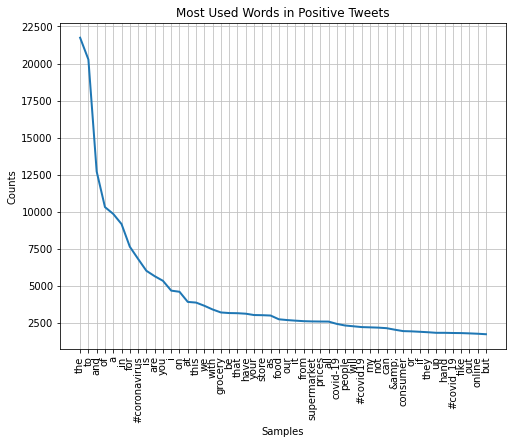

In [42]:
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Positive Tweets")
positiveFD.plot(50)
plt.show()

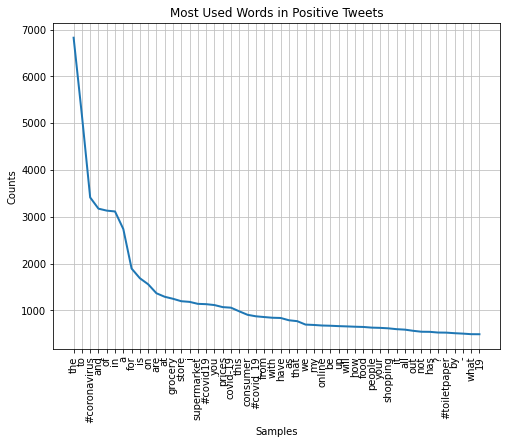

In [43]:
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Positive Tweets")
neutralDF.plot(50)
plt.show()

In [46]:
#Cleaned Dataset

cleanedData = []

lemmatizer = WordNetLemmatizer()
swords = stopwords.words("english")
for text in data_set["OriginalTweet"]:
    
    # Cleaning All links from OriginalTweet
    text = re.sub(r'http\S+', '', text)
    
    # Cleaning everything except alphabetical and numerical characters
    text = re.sub("[^a-zA-Z0-9]"," ",text)
    
    # Tokenizing and lemmatizing
    text = nltk.word_tokenize(text.lower())
    text = [lemmatizer.lemmatize(word) for word in text]
    
    # Removing stopwords
    text = [word for word in text if word not in swords]
    
    # Joining
    text = " ".join(text)
    
    cleanedData.append(text)

In [49]:
for a in range(0,3):
    print(cleanedData[a] , end = "\n\n")

advice talk neighbour family exchange phone number create contact list phone number neighbour school employer chemist gp set online shopping account po adequate supply regular med order

coronavirus australia woolworth give elderly disabled dedicated shopping hour amid covid 19 outbreak

food stock one empty please panic enough food everyone take need stay calm stay safe covid19france covid 19 covid19 coronavirus confinement confinementotal confinementgeneral



In [56]:
#Featuren Extraction
CVT = CountVectorizer(max_features=10000).fit_transform(cleanedData)


In [57]:
type(CVT)

scipy.sparse._csr.csr_matrix

In [63]:
x_train ,x_test , y_train , y_test = train_test_split(CVT ,np.asarray(data_set["Sentiment"]))

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(33716, 10000)
(11239, 10000)
(33716,)
(11239,)


In [65]:
#Model Training

start_time = time.time()

model = SVC()
model.fit(x_train,y_train)

end_time = time.time()
process_time = round(end_time-start_time,2)
print("Fitting SVC took {} seconds".format(process_time))


Fitting SVC took 285.98 seconds


In [67]:
#Predict x_test data

prediction = model.predict(x_test)

In [68]:
#Model Evaluation

In [69]:
#classification_report 

cr = classification_report(y_test,prediction)
print(cr)

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      4237
           1       0.69      0.67      0.68      2083
           2       0.81      0.83      0.82      4919

    accuracy                           0.79     11239
   macro avg       0.77      0.76      0.77     11239
weighted avg       0.78      0.79      0.79     11239



In [70]:
#Accuracy Score

AS = accuracy_score(y_test,prediction)

In [74]:
#Confusion Matrix

cm = confusion_matrix(y_test,prediction)
cm

array([[3318,  338,  581],
       [ 301, 1404,  378],
       [ 524,  288, 4107]])

<AxesSubplot:>

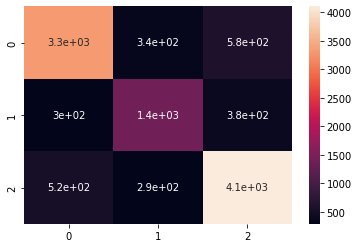

In [75]:
sns.heatmap(cm,annot = True)